In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gymnasium import spaces
from tqdm import tqdm
from matplotlib.axes import Axes
from matplotlib.figure import Figure

<h1> How convergence to mean is affected by LR, number of samples and most importantly variance/bias of a Gaussian sampled variable?</h1>

<h4>Note that the theta at any time t is an estimate of the mean E[y].</h4>

-0.00789781369540445


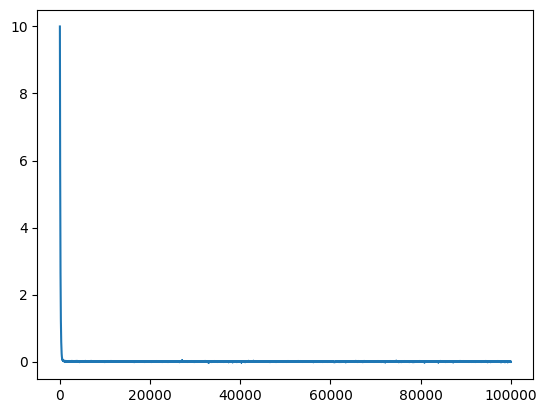

In [354]:
fig,ax = plt.subplots(1,1)
num_points = 100000
y = np.random.randn(num_points) * 0.1
x = np.arange(num_points)
theta_plt = []
theta = 10
for i in range(num_points):
    theta = theta + 0.01 * ( (y[i]+(10/(i+1))) - theta)
    theta_plt.append(theta)
ax.plot(x, theta_plt)
print(theta)

<h1> Cliff Environment </h1>

In [84]:

from gymnasium.wrappers.compatibility import LegacyEnv


class CliffEnv(LegacyEnv):
    def __init__(self,loop:bool = True):
        self.height = 4
        self.width = 12
        self.loop = loop
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(self.height),
            spaces.Discrete(self.width)
        ))
        self.moves = {
            0: (-1, 0),  # up
            1: (0, 1),  # right
            2: (1, 0),  # down
            3: (0, -1),  # left
        }

        # begin in start state
        self.reset()

    def step(self, action):
        x, y = self.moves[action]
        self.S = self.S[0] + x, self.S[1] + y

        self.S = max(0, self.S[0]), max(0, self.S[1])
        self.S = (min(self.S[0], self.height - 1),
                  min(self.S[1], self.width - 1))

        if self.S == (self.height - 1, self.width - 1):
            return self.S, -1, True, {}
        elif self.S[1] != 0 and self.S[0] == self.height - 1:
            return self.reset(), -100, not self.loop, {}
        return self.S, -1, False, {}

    def reset(self):
        self.S = (3, 0)
        return self.S


env = CliffEnv()

<h1> SARSA </h1>

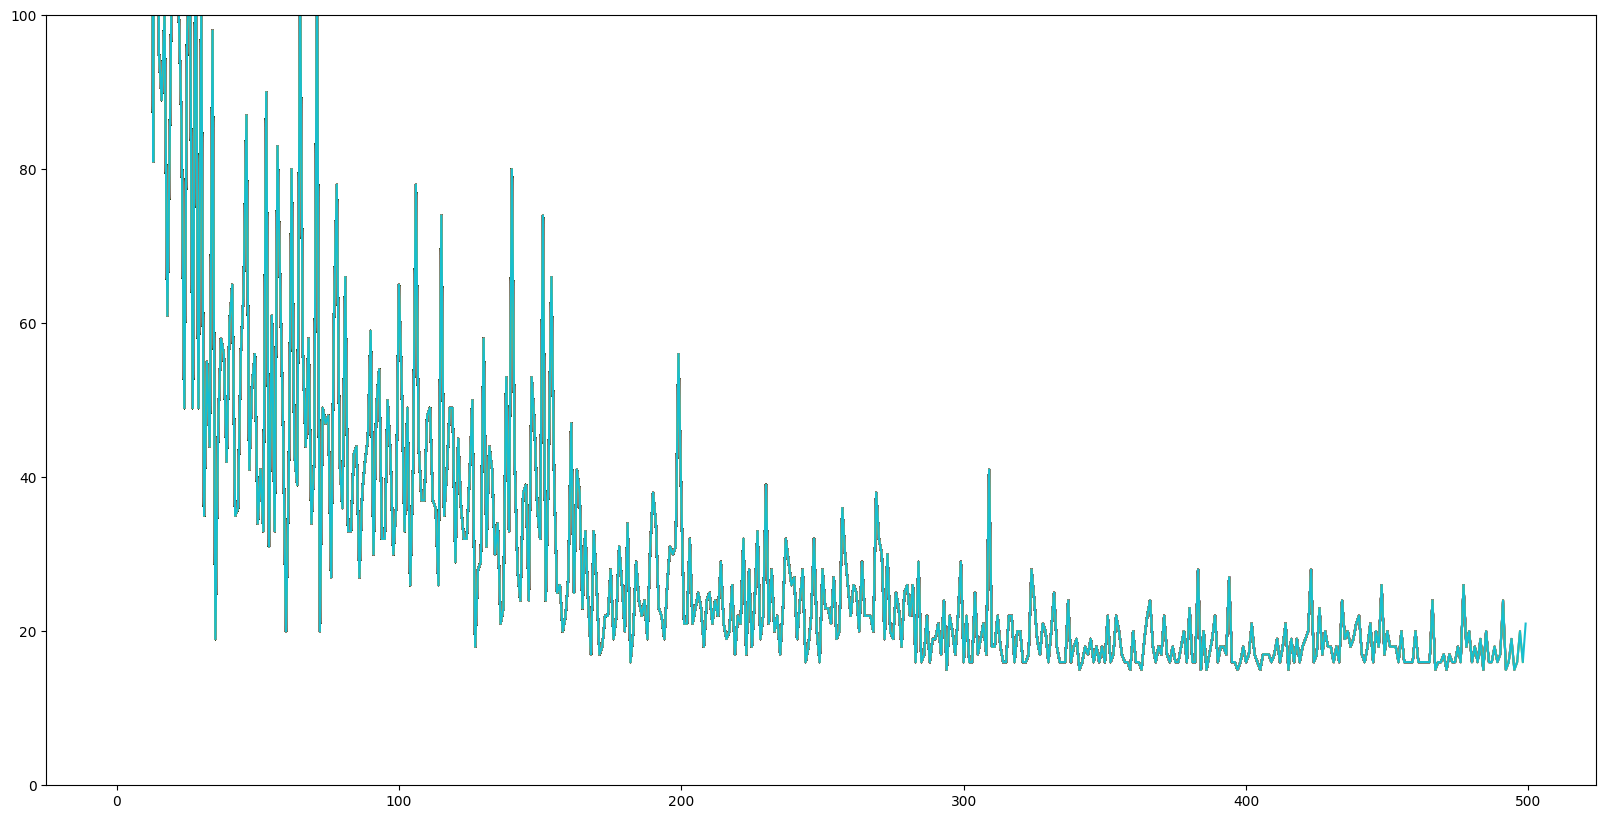

In [85]:
q = np.zeros((env.height, env.width, env.action_space.n))
epsilon = 0.1
alpha = 0.1
ep_lens = []
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.set_ylim(0, 100)
for i in range(500):
    x, y, *_ = env.reset()
    done = False
    ep_len = 0
    action = env.action_space.sample()
    while not done:
        (x_, y_), reward, done, *_ = env.step(action)
        if np.random.rand() < epsilon:
            action_ = env.action_space.sample()
        else:
            action_ = np.argmax(q[x_][y_])
        ep_len += 1
        if not done:
            q[x][y][action] = q[x][y][action] + alpha * (reward + q[x_][y_][action_] - q[x][y][action])
        else:
            q[x][y][action] = q[x][y][action] + alpha * (reward - q[x][y][action])
        x, y = x_, y_
        action = action_
    ep_lens.append(ep_len)
    plt.plot(ep_lens)



In [86]:
ep_len = 0
x, y, *_ = env.reset()
for i in range(100):
    action = np.argmax(q[x][y])
    (x_, y_), reward, done, *_ = env.step(action)
    ep_len += 1
    x, y = x_, y_
    if done:
        break
print("Eval ep len=", ep_len)

Eval ep len= 15


<h1> Q-learning </h1>

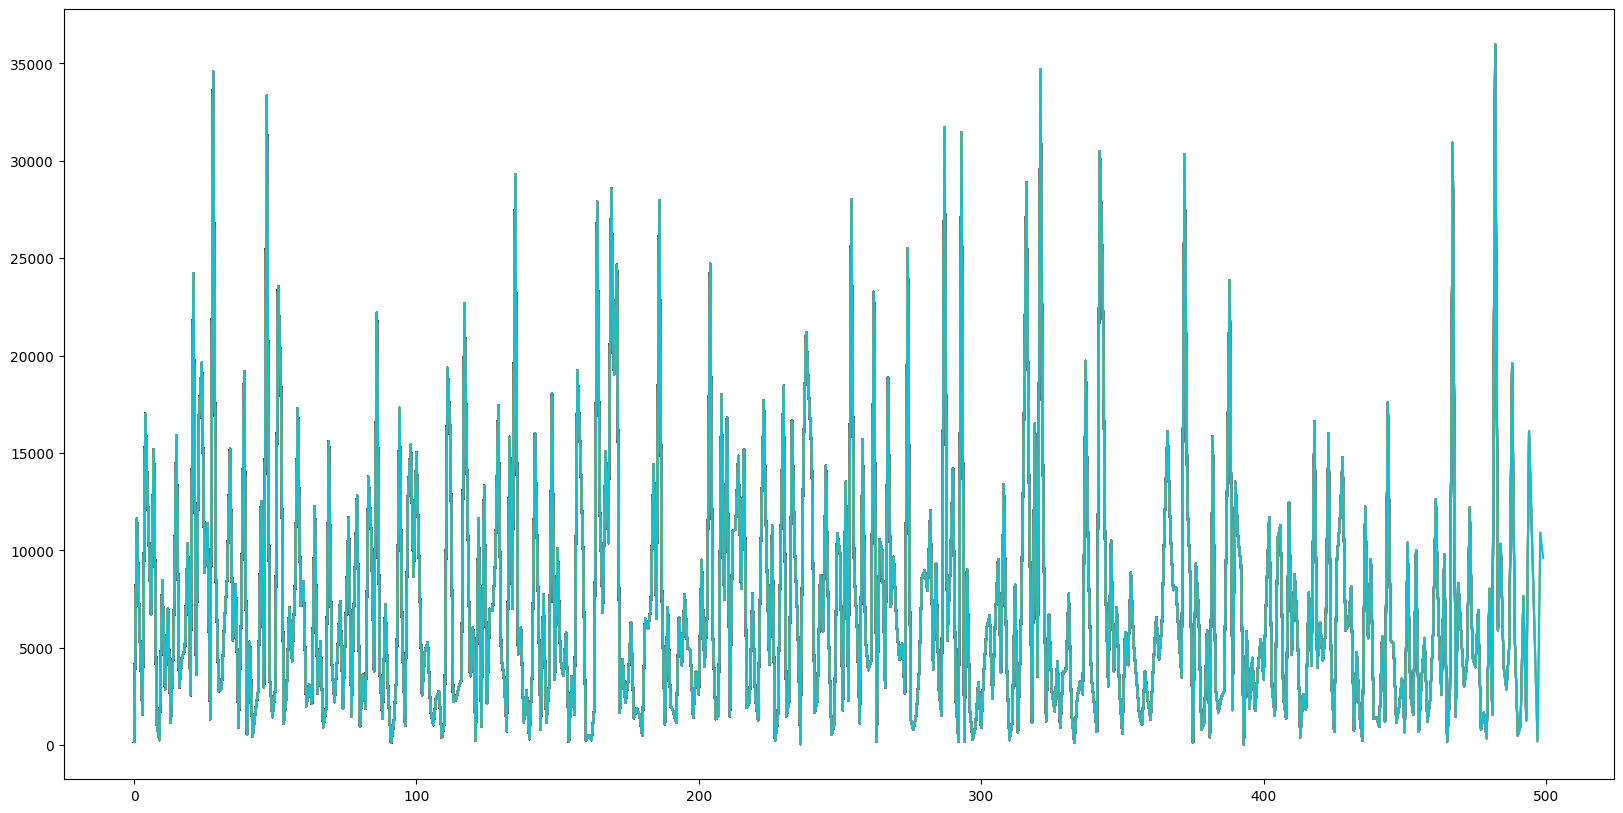

In [87]:
q = np.zeros((env.height, env.width, env.action_space.n))
alpha = 0.1
ep_lens = []
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
for i in range(500):
    x, y, *_ = env.reset()
    done = False
    ep_len = 0
    while not done:
        action = env.action_space.sample()
        (x_, y_), reward, done, *_ = env.step(action)
        action_ = np.argmax(q[x_][y_])
        ep_len += 1
        if not done:
            q[x][y][action] = q[x][y][action] + alpha * (reward + q[x_][y_][action_] - q[x][y][action])
        else:
            q[x][y][action] = q[x][y][action] + alpha * (reward - q[x][y][action])
        x, y = x_, y_
    ep_lens.append(ep_len)
    plt.plot(ep_lens)



In [88]:
ep_len = 0
x, y, *_ = env.reset()
for i in range(100):
    action = np.argmax(q[x][y])
    (x_, y_), reward, done, *_ = env.step(action)
    ep_len += 1
    x, y = x_, y_
    if done:
        break
print("Eval ep len=", ep_len)

Eval ep len= 13


<h1> Policy Gradient - REINFORCE with support for batch gradients for faster learning </h1>

In [233]:
class PomdpGrid:
    def __init__(self):
        self.s = None
    def step(self,action):
        match self.s:
            case 0:
                self.s+= action
            case 1:
                self.s += -1 if action == 1 else 1
            case 2:
                self.s+= 1 if action == 1 else -1
        return 0 if self.s==3 else -1, self.s == 3
    
    def reset(self):
        self.s = 0
        return self.s
            

In [236]:
np.random.seed(10)
NUM_TRIALS = 100
NUM_EPISODES = 1000 
BATCH_SIZE = 1
ALPHA = 2e-4
env = PomdpGrid()
returns = np.zeros(shape=(NUM_TRIALS,NUM_EPISODES))
x = np.array([[0,1],[1,0]])
def pmf():
    h = np.dot(theta, x)
    t = np.exp(h - np.max(h))
    p = t / np.sum(t)
    imin = np.argmin(p)
    epsilon = 0.05
    if p[imin] < epsilon:
        p[:] = 1 - epsilon
        p[imin] = epsilon
    return p

for trial in range(NUM_TRIALS):
    rewards = []
    theta = np.array([1.47,-1.47])
    for i in tqdm(range(NUM_EPISODES)):
        env.reset()
        experiences = []
        ret = 0
        while True:
            action = 1 if np.random.uniform() <= pmf()[1] else 0
            reward,terminated = env.step(action)
            experiences.append((action,reward))
            ret+=reward
            if terminated:
                break
        rewards.append(ret)
        #print("\rP(right)=",pmf(1),"theta0=",theta0,"theta1=",theta1,"ret=",ret,end="")
        for j in np.arange(0,len(experiences),BATCH_SIZE):
            grad = 0
            for k in range(min(BATCH_SIZE,len(experiences) - j)):
                experience = experiences[j+k]
                action = experience[0]
                grad += ret*(x[:,action] - np.dot(x,pmf()))
                ret-=experience[1]
            theta+= ALPHA*grad
    returns[trial,:] = rewards
        

100%|██████████| 1000/1000 [00:00<00:00, 4167.97it/s]


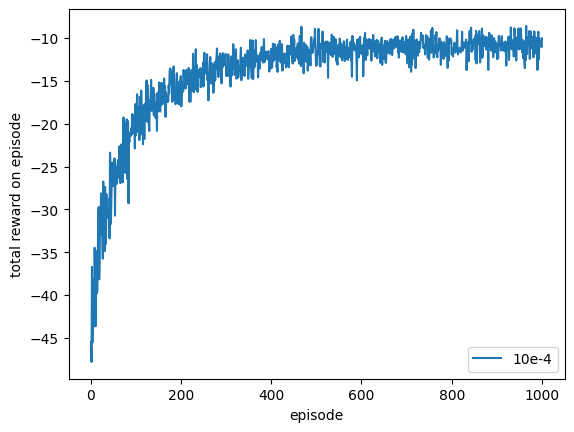

In [237]:
plt.plot(np.arange(NUM_EPISODES)+1,np.mean(returns,0),label="10e-4")
plt.legend(loc="lower right")
plt.ylabel('total reward on episode')
plt.xlabel('episode');

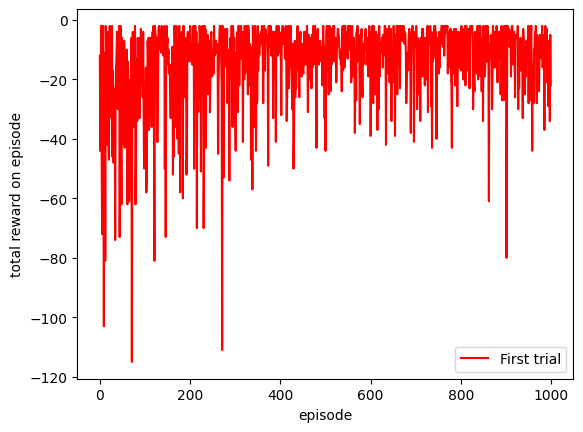

In [238]:
plt.plot(returns[0],label="First trial",color="red")
plt.legend(loc="lower right")
plt.ylabel('total reward on episode')
plt.xlabel('episode');

<h1> REINFORCE with baselines </h1>

<h4> We use batch size of 1 here and compare it with REINFORCE without baselines </h4>

In [358]:
np.random.seed(10)
NUM_TRIALS = 100
NUM_EPISODES = 1000 
BATCH_SIZE = 1
ALPHA = 2e-3
ALPHA_B = 2e-2
env = PomdpGrid()
returns_b = np.zeros(shape=(NUM_TRIALS,NUM_EPISODES))
x = np.array([[0,1],[1,0]])
weights_trials =  np.zeros(shape=(NUM_TRIALS,NUM_EPISODES))
def pmf():
    h = np.dot(theta, x)
    t = np.exp(h - np.max(h))
    p = t / np.sum(t)
    imin = np.argmin(p)
    epsilon = 0.05
    if p[imin] < epsilon:
        p[:] = 1 - epsilon
        p[imin] = epsilon
    return p


for trial in tqdm(range(NUM_TRIALS)):
    rewards = []
    weights_trial = []
    theta = np.array([1.47,-1.47])
    weight = 0.
    for i in range(NUM_EPISODES):
        env.reset()
        experiences = []
        ret = 0
        while True:
            action = 1 if np.random.uniform() <= pmf()[1] else 0
            reward,terminated = env.step(action)
            experiences.append((action,reward))
            ret+=reward
            if terminated:
                break
        rewards.append(ret)
        #print("\rP(right)=",pmf(1),"theta0=",theta0,"theta1=",theta1,"ret=",ret,end="")
        ret_w = ret
        for experience in experiences:
            action = experience[0]
            reward = experience[1]
            grad = ret_w - weight
            weight+= ALPHA_B*grad
            ret_w-=experience[1]
        weights_trial.append(weight)
        for j in np.arange(0,len(experiences),BATCH_SIZE):
            grad = 0
            for k in range(min(BATCH_SIZE,len(experiences) - j)):
                experience = experiences[j+k]
                action = experience[0]
                grad += (ret - weight) *(x[:,action] - np.dot(x,pmf()))
                ret-=experience[1]
            theta+= ALPHA*grad
    returns_b[trial,:] = rewards
    weights_trials[trial,:] = weights_trial

100%|██████████| 100/100 [00:20<00:00,  4.92it/s]

-7.884109563519582


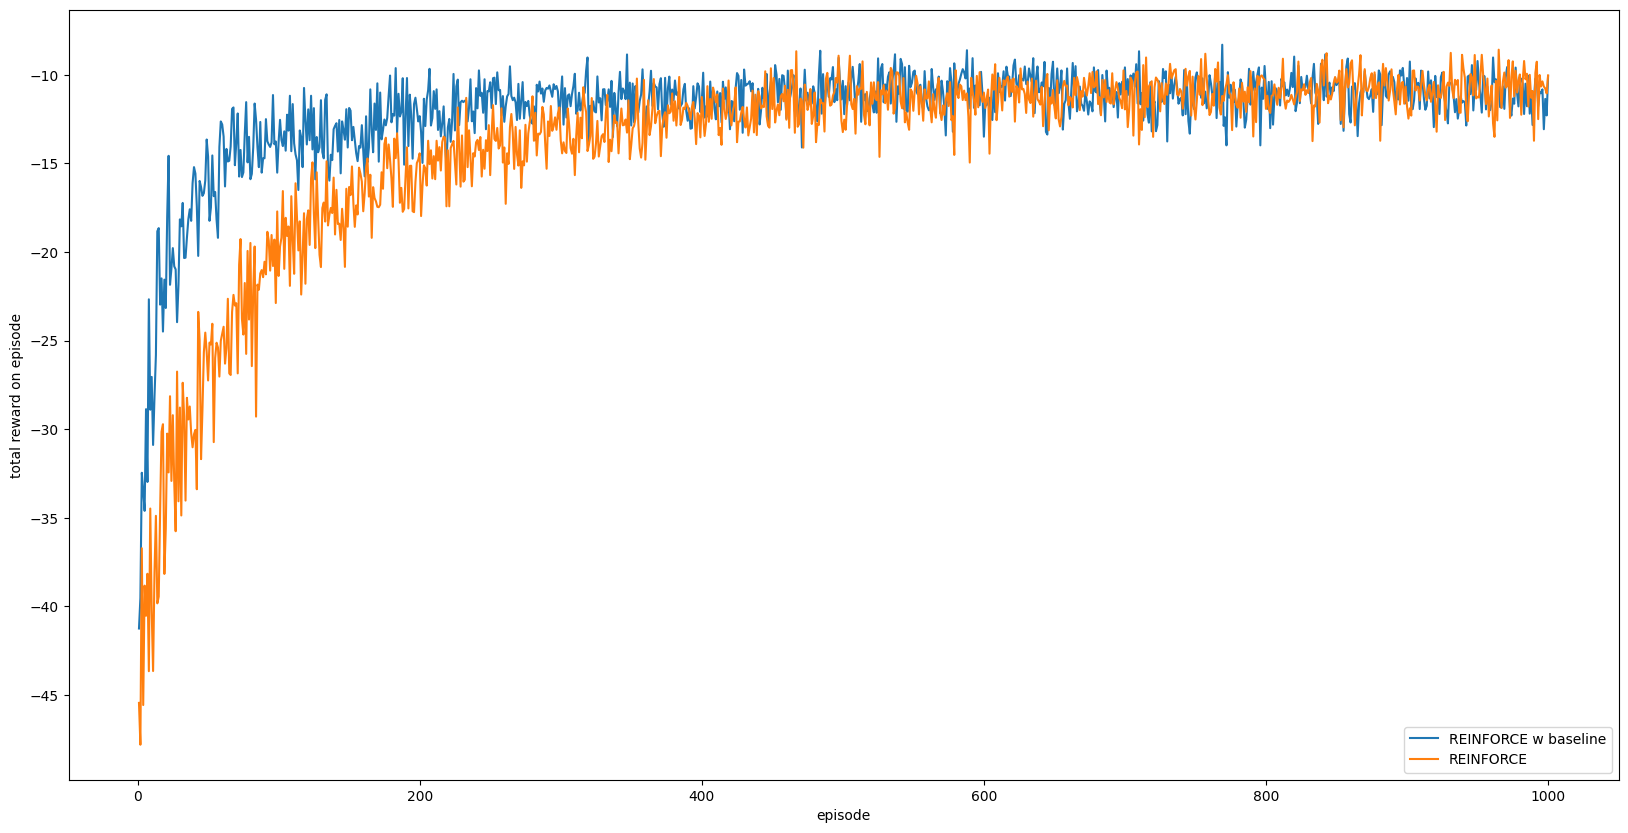

In [359]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(NUM_EPISODES)+1,np.mean(returns_b,0),label="REINFORCE w baseline")
plt.plot(np.arange(NUM_EPISODES)+1,np.mean(returns,0),label="REINFORCE")
plt.legend(loc="lower right")
plt.ylabel('total reward on episode')
plt.xlabel('episode');

v(s0)= -7.884109563519582
PMF= [0.43751511 0.56248489]


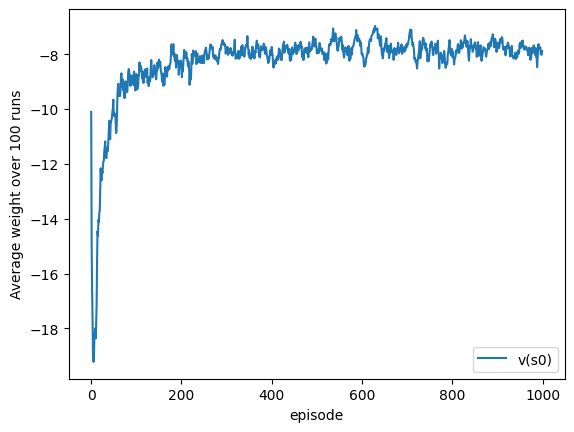

In [362]:
plt.plot(np.mean(weights_trials,axis=0),label="v(s0)")
plt.xlabel("episode")
plt.ylabel("Average weight over 100 runs")
plt.legend(loc="lower right")
print("v(s0)=",np.mean(weights_trials[:,-1]))
print("PMF=",pmf())

num_encoding*num_actions num_actions*1

<h1> Actor Critic </h1>

In [81]:
NUM_TRIALS = 1
NUM_EPISODES = 10000
ALPHA_W = 0.01
ALPHA_T = 2e-2
env = CliffEnv(False)
returns = np.zeros((NUM_TRIALS,NUM_EPISODES))
ep_lens = np.zeros((NUM_TRIALS,NUM_EPISODES))

def pmf_cliff(s):
    exp_h = np.exp(h[*s])
    pmf_c = exp_h/np.sum(exp_h)
    return pmf_c

def encoding(s,a):
    vec = np.zeros((env.height, env.width, env.action_space.n))
    vec[*s,a] = 1
    return vec

for i in tqdm(range(NUM_TRIALS)):
    v = np.zeros((env.height, env.width))
    h = np.zeros((env.height, env.width, env.action_space.n))
    for j in range(NUM_EPISODES):
        state = env.reset()
        ret = 0.
        ep_len = 0
        while True:
            action = np.random.choice([0,1,2,3],1,p=pmf_cliff(state)).item()
            next_state,reward,terminated,_ = env.step(action)
            ret+=reward
            ep_len+=1
            value_next_state = 0
            if not terminated:
                value_next_state = v[*next_state]
            delta = reward+value_next_state - v[*state]
            v[*state]+= ALPHA_W*(delta)
            mul1 = np.expand_dims(pmf_cliff(state),axis=1)
            mul2 = np.array([encoding(state,x) for x in range(env.action_space.n)]).T
            mul1 = np.squeeze(mul2@mul1)
            h += ALPHA_T*(delta)*( encoding(state,action) - mul1 )
            if terminated or ep_len >= 100:
                break
            state = next_state
        returns[i,j] = ret    
        ep_lens[i,j] = ep_len

100%|██████████| 1/1 [00:03<00:00,  3.62s/it]


Text(0, 0.5, 'Mean episode length averaged over 1 episodes')

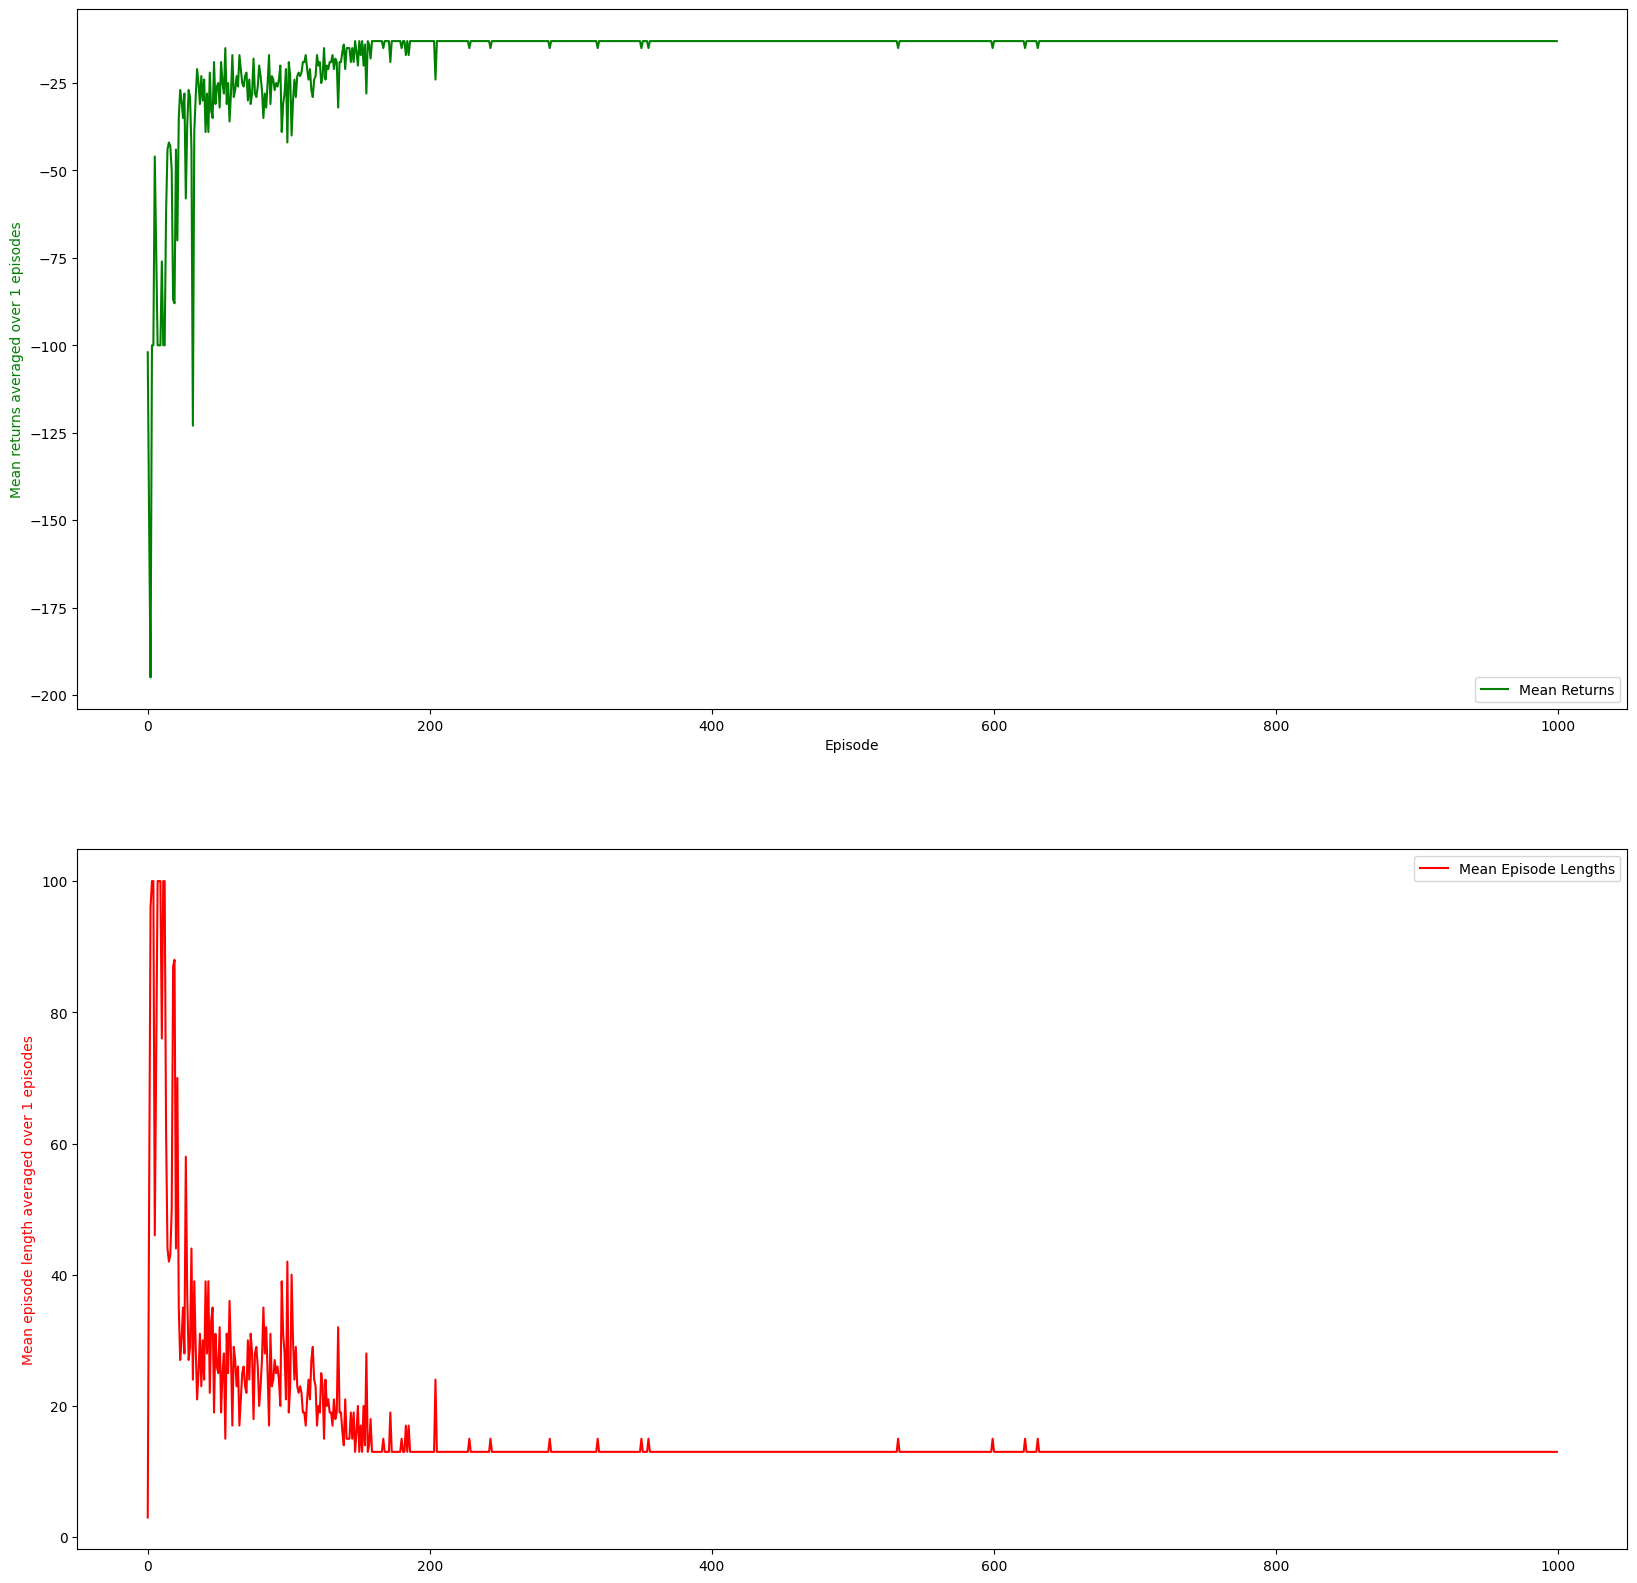

In [82]:
fig:Figure
ax1:Axes
fig,(ax1,ax2) = plt.subplots(2,1)
fig.set_figwidth(20)
fig.set_figheight(20)
ax1.plot(np.mean(returns,axis=0)[0:-1:10],"g-",label="Mean Returns")
ax2.plot(np.mean(ep_lens,axis=0)[0:-1:10],"r-",label="Mean Episode Lengths")
ax1.legend(loc="lower right")
ax2.legend(loc="upper right")
ax1.set_xlabel("Episode")
ax1.set_ylabel(f"Mean returns averaged over {NUM_TRIALS} episodes",color="g")
ax2.set_ylabel(f"Mean episode length averaged over {NUM_TRIALS} episodes",color="r")

In [93]:
print("J(theta)=v(s0)=",v[3,0],"\nReturns of last 10 episodes=",returns[0,-10:])

J(theta)=v(s0)= -13.123167758866222 
Returns of last 10 episodes= [-13. -13. -13. -13. -13. -13. -13. -13. -13. -13.]
